In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import yfinance as yf
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet

import pypfopt
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt import HRPOpt
from pypfopt.efficient_frontier import EfficientCVaR

import plotly.graph_objects as go
import plotly.express as px



f:\anaconda\envs\Project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def Mean_Variance_Optimization(data,latest_prices,portfolio_value):
    
    Mean_Historical_Return = mean_historical_return(data)
    Covariance_Shrinkage = CovarianceShrinkage(data).ledoit_wolf()

    Efficient_Frontier = EfficientFrontier(Mean_Historical_Return, Covariance_Shrinkage)
    weights = Efficient_Frontier.max_sharpe()
    
    cleaned_weights = Efficient_Frontier.clean_weights()
    
    performance = Efficient_Frontier.portfolio_performance(verbose=False)

    Discrete_Allocation = DiscreteAllocation(weights, latest_prices, total_portfolio_value=portfolio_value)
    
    allocation, leftover = Discrete_Allocation.greedy_portfolio()
    
    allocation={key: value for key, value in allocation.items() if value >= 0}
    
    latest_prices.loc[list(allocation.keys())]

    value=latest_prices.loc[list(allocation.keys())]*list(allocation.values())

    value[value > 0].sum()

    performance = list(performance)

    performance[0] = performance[0]*100
    performance[1] = performance[1]*100


    return(allocation,leftover,performance)

In [4]:
def Hierarchical_Risk_parity(data,latest_prices,portfolio_value):
    
    returns = data.pct_change().dropna()

    hrp = HRPOpt(returns)
    hrp_weights = hrp.optimize()

    hrp.portfolio_performance(verbose=False)
    
    print(dict(hrp_weights))

    da_hrp = DiscreteAllocation(hrp_weights, latest_prices, total_portfolio_value=100000)
    
    allocation, leftover = da_hrp.greedy_portfolio() 
    
    print("Discrete allocation (HRP):", allocation)
    
    print("Funds remaining (HRP): ${:.2f}".format(leftover))

In [5]:
def diversify():
    gics_sectors = [
        'XLC',  # Communication Services
        'XLY',  # Consumer Discretionary
        'XLP',  # Consumer Staples
        'XLE',  # Energy
        'XLF',  # Financials
        'XLI',  # Industrials
        'XLB',  # Materials
        'XLRE', # Real Estate
        'XLK',  # Information Technology
        'XLU',  # Utilities
        'XLV', # Health Care 
        ]
    start_date = "2020-01-01"
    end_date = "2023-06-19"

    data = yf.download(gics_sectors, start=start_date, end=end_date, progress=False)

    # Initialize a dictionary to store the returns
    returns_dict = {}

    # Initialize a list to store the forecasted dataframes
    forecast_dfs = []

    data_close = data['Adj Close']

    data_close = data_close.reset_index(inplace=False)

    # Iterate over each stock symbol
    for symbol in gics_sectors:
        
        # Reset the index and keep only 'Date' and 'Close' columns
        stock_data = data_close[['Date', symbol]]
        stock_data.columns = ['ds', 'y']
        
        # Create and fit the Prophet model
        model = Prophet()
        model.fit(stock_data)

        # Generate future dates
        future_dates = model.make_future_dataframe(periods=365)

        # Make predictions
        forecast = model.predict(future_dates)

        # Extract the relevant columns from the forecast
        forecast_subset = forecast[['ds', 'yhat']]

        # Filter the forecast for next year's data
        next_year_forecast = forecast_subset[forecast_subset['ds'].dt.year == forecast_subset['ds'].dt.year.max()]

        # Calculate the percentage change in stock prices
        start_price = next_year_forecast.iloc[0]['yhat']
        end_price = next_year_forecast.iloc[-1]['yhat']
        returns = (end_price - start_price) / start_price * 100

        # Store the returns in the dictionary
        returns_dict[symbol] = returns

        # Store the forecast dataframe
        forecast_dfs.append(forecast_subset)

    returns = data['Adj Close'].pct_change().dropna()
    cumulative_returns = (1 + returns).cumprod()

    growth_percentages = {}
    for symbol in gics_sectors:
        sector_data = data['Adj Close'][symbol]
        growth_percentage = (sector_data[-1] - sector_data[0]) / sector_data[0] * 100
        growth_percentages[symbol] = growth_percentage

    # diversity of stock using growth percentages
    # Calculate the sum of all values in the dictionary
    sum_values = sum(growth_percentages.values())

    # Calculate the percentage for each value
    percentages = {key:  round((value / sum_values) * 100,0) for key, value in growth_percentages.items()}

    new_keys = ['Communication Services','Consumer Discretionary','Consumer Staples','Energy','Financials','Industrials','Materials','Real Estate', 'Information Technology' ,'Utilities', 'Health Care']

    for i, old_key in enumerate(list(percentages.keys())):
        new_key = new_keys[i]
        percentages[new_key] = percentages.pop(old_key)

    plt.figure(figsize=(12, 6))

    for sector in cumulative_returns.columns:
        plt.plot(cumulative_returns.index, cumulative_returns[sector], label=sector)

    plt.title("GICS Sector Cumulative Returns")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Returns")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot the forecasted stock prices for all stocks in a single figure
    plt.figure(figsize=(12, 8))
    for i, forecast_df in enumerate(forecast_dfs):
        symbol = gics_sectors[i]
        plt.plot(forecast_df['ds'], forecast_df['yhat'], label=symbol)

    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.title('Stock Price Forecast')
    plt.legend()
    plt.show()

    return(percentages)


In [24]:
def risk_reducing():
    df = pd.read_csv('Data/Stock_History/closing.csv')
    df = df.dropna(axis=1)
    df = df.drop('Date', axis=1)

    # Extract the closing prices
    closing_prices = df

    stock_symbols = list(df.columns.values)

    # Calculate risk metric (example: standard deviation of daily returns)
    risk_metric = closing_prices.pct_change().std()


    scaler = MinMaxScaler()
    normalized_risk = scaler.fit_transform(risk_metric.values.reshape(-1, 1))

    # Apply k-means clustering
    k = 3  # Number of clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(normalized_risk)

    # Get the cluster labels for each stock
    cluster_labels = kmeans.labels_

    # Plot the clustering results
    plt.figure(figsize=(10, 6))
    colors = ['r', 'g', 'b']  # Colors for the clusters

    for i, label in enumerate(cluster_labels):
        plt.scatter(i, risk_metric[i], color=colors[label], alpha=0.7)

    # Highlight the high-risk stocks
    high_risk_stocks = [stock_symbols[i] for i, label in enumerate(cluster_labels) if label == 2]
    high_risk_indices = [i for i, label in enumerate(cluster_labels) if label == 2]
    
    return(high_risk_stocks)

19:52:35 - cmdstanpy - INFO - Chain [1] start processing
19:52:35 - cmdstanpy - INFO - Chain [1] done processing
19:52:36 - cmdstanpy - INFO - Chain [1] start processing
19:52:36 - cmdstanpy - INFO - Chain [1] done processing
19:52:37 - cmdstanpy - INFO - Chain [1] start processing
19:52:37 - cmdstanpy - INFO - Chain [1] done processing
19:52:38 - cmdstanpy - INFO - Chain [1] start processing
19:52:38 - cmdstanpy - INFO - Chain [1] done processing
19:52:39 - cmdstanpy - INFO - Chain [1] start processing
19:52:40 - cmdstanpy - INFO - Chain [1] done processing
19:52:40 - cmdstanpy - INFO - Chain [1] start processing
19:52:41 - cmdstanpy - INFO - Chain [1] done processing
19:52:42 - cmdstanpy - INFO - Chain [1] start processing
19:52:42 - cmdstanpy - INFO - Chain [1] done processing
19:52:43 - cmdstanpy - INFO - Chain [1] start processing
19:52:43 - cmdstanpy - INFO - Chain [1] done processing
19:52:44 - cmdstanpy - INFO - Chain [1] start processing
19:52:44 - cmdstanpy - INFO - Chain [1]

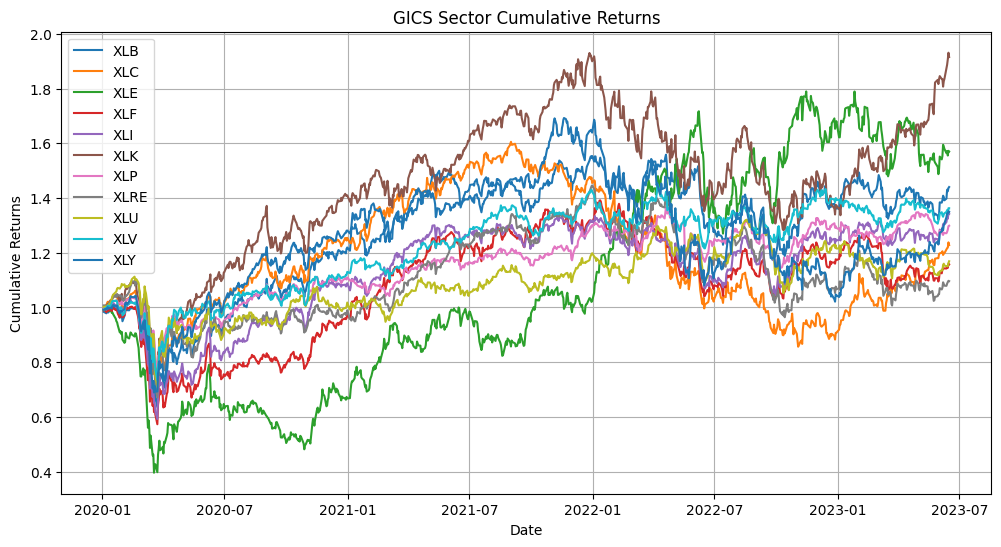

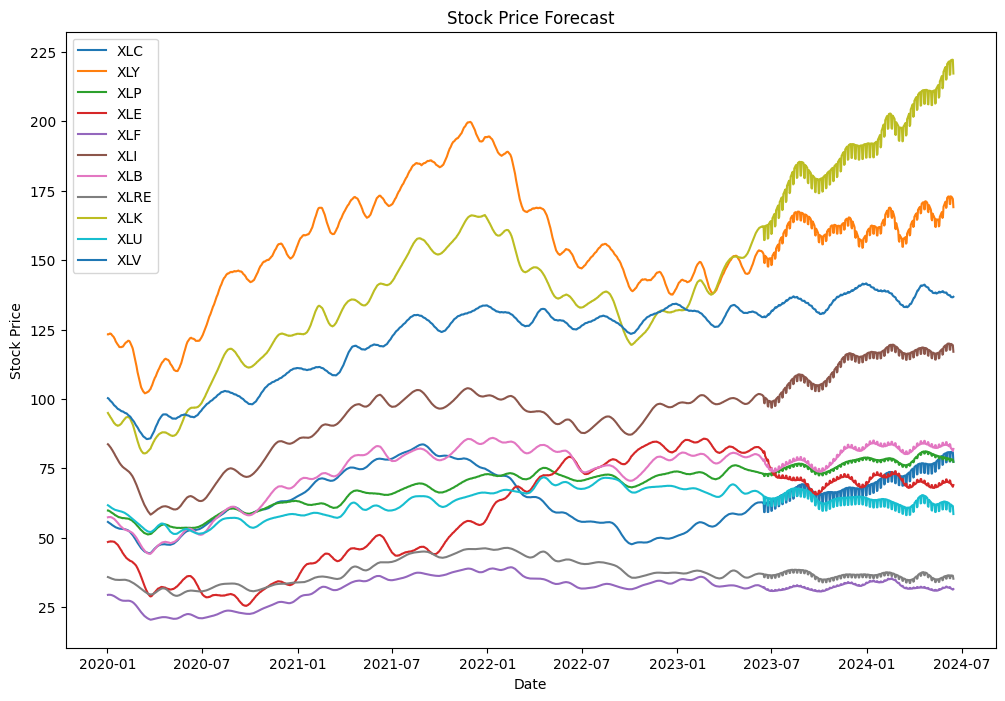

In [7]:
divers= diversify()

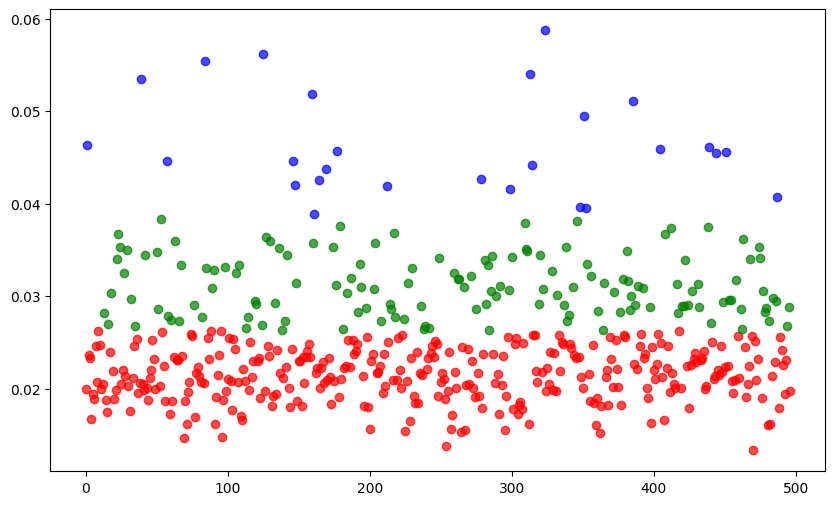

In [25]:
high_risk_stocks = risk_reducing()

In [32]:
portfolio = pd.read_csv("data/Stock_History/closing.csv")
portfolio = portfolio.drop(columns=high_risk_stocks)

company = pd.read_csv("data/company_data.csv")
company = company.loc[company['Symbol'].isin(portfolio.columns)]

In [29]:
total_portfolio_value=100000
latest_prices = get_latest_prices(portfolio.iloc[:, 1:])

In [30]:
for key, value in divers.items():
    divers[key] = total_portfolio_value/100*value

In [33]:
allocation = []
leftover = 0
performance = []

for key, value in divers.items():
    allo,leftover,perf = Mean_Variance_Optimization(portfolio[list(company[company['GICS Sector'] == key].Symbol)],
                               get_latest_prices(portfolio[list(company[company['GICS Sector'] == key].Symbol)]),
                               (value+leftover))
    allocation.extend(list(allo.items()))
    performance.extend([perf]) 
result = [sum(elements) for elements in zip(*performance)]
result = [value / len(performance) for value in result]

print('Leftover',leftover)
result = [sum(elements) for elements in zip(*performance)]
performance = [value / len(performance) for value in result]
print('Expected annual return',performance[0],
        '\nAnnual volatility',performance[1],
        '\nSharpe Ratio',performance[2])

Leftover 163.53681951761246
Expected annual return 38.01762823888664 
Annual volatility 32.29106473674756 
Sharpe Ratio 1.1907894667741983


In [13]:
stock_portfolio = pd.DataFrame(allocation, columns=['Stock', 'Size'])

In [14]:
fig = px.pie(stock_portfolio, values='Size', names='Stock', title='Stock Distribution')

fig.show()

In [15]:
fig = go.Figure(data=[go.Table(
    header=dict(values=list(stock_portfolio.columns),
                fill_color='paleturquoise'),
    cells=dict(values=[stock_portfolio.Stock, stock_portfolio.Size],
               fill_color='lavender')
               )
])

fig.show()